### Importing Libraries

In [1]:
#importing Libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math
import time
% matplotlib inline

### Making master dataset to be used in random forrest

In [ ]:
#Importing Original File
data = pd.read_csv('CloudFactory_DataSet_Accuracy_Prediction.tsv', sep='\t')

#Replacing All 'Nan' values in original data ('keypress_keytypeint', 'mouseclick_button' & 'mousemove_distance') by 0
data.fillna(value =0, inplace = True)

#Assigning new column to original data as 'keytype_changed'
data = data.assign(keytype_changed= 0)

#List of all unique tasks
tasks = data['task_id'].unique

#creating new dataframe with relevant columns
master = pd.DataFrame(columns = ['task_id','worker_id','keypress_keytypeint','mousemove_distance','mouseclick_button','work_duration','accuracy'])

#Calculating number of time keytype is changed
j = 1
for i in ids:
    m = pd.DataFrame(data[data['task_id'] == i])
    m.reset_index(drop = True, inplace = True)
    maxi = m.shape[0]
    print (j)
    j = j+1 
    for i in range(0, maxi-1):
        if m['keypress_keytypeint'][i] != m['keypress_keytypeint'][i+1]:
            m['keytype_changed'][i+1] =1
    frames = [master, m]
    master = pd.concat(frames)        
    
    
#Groupby by task_id 
data = data.groupby(['worker_id','task_id']).mean()
data = data.reset_index(level=0)
data = data.reset_index(level = 0)

#Deleting timestamp column
del data['timestamp']

#Creating 'Error' column from 'Accuracy' column (Error is binary variable)
data['accuracy'] = (data['accuracy'] * 6).round()
data.loc[data['accuracy']!=6, 'error' ] = 1
data.loc[data['accuracy']==6, 'error'] = 0

#Adding 'mousemove_distance_time', 'mouseclick_button_time','keytype_changed_time'
main_data = pd.read_csv('CloudFactory_DataSet_Accuracy_Prediction.tsv', sep='\t')

data['mousemove_distance_time']=0
data['mouseclick_button_time']=0
data['keytype_changed_time']=0

i = 1
for task in tasks:
    print (i)
    i = i+1
    x = main_data[main_data['task_id']==task].shape[0]/data[data['task_id']==task]['work_duration']
    data.loc[data['task_id']== task, 'mousemove_distance_time'] = data[data['task_id']== task]['mousemove_distance']* x
    data.loc[data['task_id']== task, 'mouseclick_button_time'] = data[data['task_id']== task]['mouseclick_button']* x
    data.loc[data['task_id']== task, 'keytype_changed_time'] = data[data['task_id']== task]['keytype_changed']* x
    
    
#making 13*13 transition matrxin and ataching it infront of data
data1 = data
data = pd.read_csv('CloudFactory_DataSet_Accuracy_Prediction.tsv', sep='\t')

data['keypress_keytypeint'].fillna(value = 0, inplace = True)

data.assign(error = 0)
data['accuracy'] = data['accuracy'] * 6
data['accuracy'].round(decimals  =2 )
data.loc[data['accuracy']!=6,'error'] =1
data['error'].fillna(value = 0, inplace = True)


transition = np.zeros((5000,13,13))
transition_norm = np.zeros((5000,13,13))

tasks = data1['task_id']
for i,task in enumerate (tasks):
    df = data[data['task_id']==task].reset_index(level=0, drop = True)
    print (i , task)
    #print (df)
    for index,row in df.iterrows():
        #print (index)

        # Think of different task_ids
        if index == 0:
            continue
        #row['keypress_keytypeint'] != df.loc[index - 1]['keypress_keytypeint']:
        entry = np.int(df.loc[index - 1]['keypress_keytypeint'])
        exit = np.int(df.loc[index]['keypress_keytypeint'])
        transition[i,entry,exit] += 1      
            
    transition[i] = np.array(transition[i])
    transition_norm[i] = transition[i]/df.shape[0]

            
trans_row = pd.DataFrame()
for i in range (0,5000):
    a = pd.DataFrame(transition_norm[i].transpose().reshape(169)).transpose()
    trans_row = trans_row.append(a)

trans_row.reset_index(level=0,drop = True, inplace = True)
all_variable = pd.concat([data1,trans_row], axis =1)


#Incorporating Demographic information in this model 
worker = pd.read_csv('receipt_worker_profile (1).tsv', sep='\t')
worker.dropna(axis=0, inplace = True)

#worker['academic_degree'].unique()

worker = worker.assign(Education = 0)

worker.loc[worker['academic_degree']=='["Higher Secondary or equivalent level"]', 'Education'] = 1
worker.loc[worker['academic_degree']=='[]','Education'] = 1 
worker.loc[worker['academic_degree']=='["Bachelor\'s or equivalent level"]','Education'] = 2
worker.loc[worker['academic_degree']=='["Master\'s or equivalent level"]','Education'] = 3
worker.loc[worker['academic_degree']=='["Secondary or equivalent level"]','Education'] = 0
worker.loc[worker['academic_degree']=='["Master\'s or equivalent level", "Bachelor\'s or equivalent level", "Higher Secondary or equivalent level"]','Education'] = 3
worker.loc[worker['academic_degree']=='["Higher Secondary or equivalent level", "Bachelor\'s or equivalent level", "Master\'s or equivalent level"]','Education'] = 3
worker.loc[worker['academic_degree']=='["Bachelor\'s or equivalent level", "Higher Secondary or equivalent level", "Secondary or equivalent level"]','Education'] = 2
worker.loc[worker['academic_degree']=='["Bachelor\'s or equivalent level", "Master\'s or equivalent level"]','Education'] = 2
worker.loc[worker['academic_degree']=='["Higher Secondary or equivalent level", "Bachelor\'s or equivalent level"]','Education'] = 2
worker.loc[worker['academic_degree']=='["Higher Secondary or equivalent level", "Secondary or equivalent level"]','Education'] = 2


worker = worker.assign(Sex = 0)
worker.loc[worker['gender'] == 'Male', 'Sex'] = 1
worker.loc[worker['gender'] == 'Female', 'Sex'] = 0


worker['onbarded_date'] = pd.to_datetime(worker['onbarded_date'])
today = datetime.date.today()
worker =worker.assign(experience = 0)
worker['experience'] = today - worker['onbarded_date']
worker = worker.assign(exp = 0)
worker['exp'] = worker['experience'].dt.days/365

df = pd.merge(all_variable, worker, on='worker_id')

#Exporting this df as 'all_variable_master' file
pd.to_csv('all_variable_master.csv')


### Visualization of correlation matrix 

In [ ]:
df = pd.read_csv('all_variable_master.csv')

df2=df[['Education', 'Sex', 'exp', 'speed', 'work_duration',
       'keytype_changed', 'mouseclick_button', 'mousemove_distance',
       'keytype_changed_time','mouseclick_button_time','mousemove_distance_time','error']]
corrmat = df2.corr()
fig, ax = plt.subplots(figsize=(15, 12))
sns.set(font_scale=1.5)
ax.get_figure()
sns.heatmap(corrmat, vmax=.25, square=True ,annot=True)
#fig.savefig("correlation.png")
plt.close(fig)

### Running Random Forrest and visualizing the results

Random Forrest is running
[[104  22]
 [ 43  80]]
             precision    recall  f1-score   support

          0       0.71      0.83      0.76       126
          1       0.78      0.65      0.71       123

avg / total       0.75      0.74      0.74       249



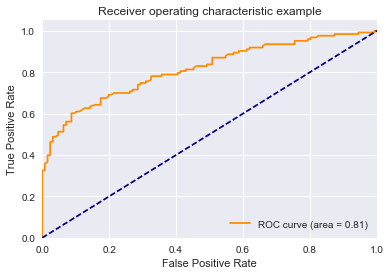

Area Under the ROC Curve is  0.814298619177


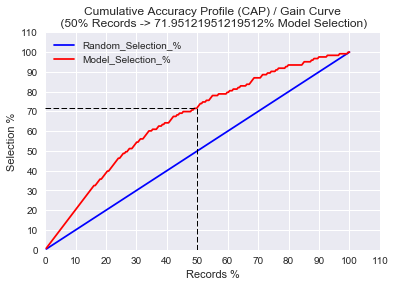

In [45]:
#Importing data
data = pd.read_csv('all_variable_master.csv')


#Selecting X and Y
x = data[data.columns[1:181]]
y = data['error']


#Standardization of X
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
x = sc.fit_transform(x)


#Train Test Split (test size can be selected here)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 100 )

print ('Random Forrest is running')

#Importing logistic resgression and fitting it to data
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 800)
model.fit(x_train,y_train) 

#Making predictions from test data
predictions = model.predict(x_test)
y_score = model.predict_proba(x_test)


#Printing results 
from sklearn.metrics import classification_report, confusion_matrix
print (confusion_matrix(y_test, predictions))
print (classification_report(y_test, predictions))


from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
print('Area Under the ROC Curve is ', roc_auc[1])

#CAP CURVE 
# Create CAP dataset
Y_cap = np.c_[y_test,y_score[:, 1:]]
df = pd.DataFrame(data=Y_cap)
df = df.sort_values([1], ascending=False).reset_index('index', drop=True)
#df.to_csv('CAP.csv',sep=';')
 
percent = 50    

# Append relevant columns to df to construct CAP figure
records = len(df.index)           # total records
n_acted = df[0].sum()             # total action
df['Records_%'] = pd.Series((np.linspace(1,records,records)/records)*100, index = df.index)
df['Random_Selection_%'] = df['Records_%']
df['Model_Selection_%'] = pd.Series(np.ones(records), index = df.index)
for i in range(1, records):
    df['Model_Selection_%'][i] = df[0][i] + df['Model_Selection_%'][i-1]
df['Model_Selection_%']=(df['Model_Selection_%']/n_acted)*100


# Obtain % Model Selection value (interpolate if necessary)
val_y1 = df[df['Records_%']<=percent].iloc[-1]['Model_Selection_%']
val_y2 = df[df['Records_%']>=percent].iloc[0]['Model_Selection_%']
if val_y1 == val_y2:
    val = val_y1*1.0
else:
    val_x1 = df[df['Records_%']<=percent].iloc[-1]['Records_%']
    val_x2 = df[df['Records_%']>=percent].iloc[0]['Records_%']
    val = val_y1 + ((val_x2 - percent)/(val_x2 - val_x1))*(val_y2 - val_y1)
 

#Visualising the Cumulative Accuracy Profile (CAP / Gain Curve)
fig, ax = plt.subplots(nrows = 1, ncols = 1)  # create figure & 1 axis
ax.plot(df['Records_%'], df['Random_Selection_%'], color = 'blue')
ax.plot(df['Records_%'], df['Model_Selection_%'], color = 'red')

# Add dotted lines to chosen % Records
ax.plot([percent, percent], [0.0, val], color='k', linestyle='--', linewidth=1)
ax.plot([0, percent], [val, val], color='k', linestyle='--', linewidth=1)
plt.title('Cumulative Accuracy Profile (CAP) / Gain Curve'+
          '\n ({a}% Records -> {b}% Model Selection)'.format(a = percent, b = val))
plt.xlabel('Records %')
plt.ylabel('Selection %')
plt.xlim(0.0, 110.0)
plt.xticks(np.linspace(0.0, 110, 12))
plt.ylim(0.0, 110.0)
plt.yticks(np.linspace(0.0 ,110 , 12))
plt.legend()
plt.show()
fig.savefig('CAP-logit.png', bbox_inches = 'tight')
plt.close(fig)



## Real-Time-Error-Detection

### For Deciding boundry

In [54]:
#Importing data
data = pd.read_csv('all_variable_master.csv')


#Selecting X and Y
x = data[data.columns[1:181]]
y = data['error']


#Standardization of X
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
x = sc.fit_transform(x)


#Train Test Split (test size can be selected here)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.05, random_state = 100 )

print ('Random Forrest is running')

#Importing logistic resgression and fitting it to data
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 800)
model.fit(x_train,y_train) 

#Making predictions from test data
predictions = model.predict(x_test)
y_score = model.predict_proba(x_test)

predictions = y_score[:,1]

boundry = 0.65

shape = predictions.shape[0]
for i in range(0,shape):
    if predictions[i] >=boundry:
        predictions[i] = int(1)
    else:
        predictions[i] = int(0)

from sklearn.metrics import classification_report, confusion_matrix
print (confusion_matrix(y_test, predictions))
print (classification_report(y_test, predictions))


Random Forrest is running
[[123   3]
 [ 71  52]]
             precision    recall  f1-score   support

          0       0.63      0.98      0.77       126
          1       0.95      0.42      0.58       123

avg / total       0.79      0.70      0.68       249



### Real-time-error prediction

In [58]:
main = pd.read_csv('all_variable_master.csv')
y = main['error']
main.drop(['error'], axis =1, inplace = True)
x = main

#Importing train_test_split and applying it to X and Y
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.05, random_state =101)
x_train.drop(['task_id'], axis =1, inplace = True)
#x_test.drop(['task_id'], axis =1, inplace = True)


from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
x = sc.fit_transform(x_train)
x_train = x

#Importing logistic resgression and fitting it to data
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 400)
model.fit(x_train,y_train)

original = pd.read_csv('CloudFactory_DataSet_Accuracy_Prediction.tsv', sep='\t')
original['keypress_keytypeint'].fillna(value = 0, inplace = True)

tasks = ['57a2a002296d6d22f946f089','57a3fc0a296d6d0fd5c9b506','57a2b020296d6d729dc9b270']

for task in tasks:
    print ('---------------------------')
    print ('---------------------------')
    print ('You are working on a task id ' + str(task))
    temp = original[original['task_id'] == task].reset_index(level=0, drop = True)
    df_ = main [main['task_id']==task]
    #print(df_)
    shape = temp.shape[0]
    transition = np.zeros((13,13))
    transition_norm = np.zeros((13,13))
    for i in range(0,shape):
        perc = (i+1)/shape * 100
        df = temp.head(i+1)
        df.reset_index(level=0, drop= True, inplace = True)
        for index,row in df.iterrows():
            # Think of different task_ids
            if index == 0:
                continue

            entry = np.int(df.loc[index - 1]['keypress_keytypeint'])
            exit = np.int(df.loc[index]['keypress_keytypeint'])
            transition[entry,exit] += 1      

        transition = np.array(transition)
        transition_norm = transition/df.shape[0]

        trans_row = pd.DataFrame()
        a = pd.DataFrame(transition_norm.transpose().reshape(169)).transpose()
        trans_row = trans_row.append(a)

        trans_row.reset_index(level=0,drop = True, inplace = True)
        temp_ = df_[df_.columns[0:12]]
        temp_.reset_index(level=0, drop = True,inplace = True)
        x_test_ = pd.concat([temp_,trans_row], axis =1)
        x_test_.drop(['task_id'], axis =1, inplace = True)
        prob = model.predict_proba(x_test_)
        y_score = prob[0][1]
        print ('------------')
        print (str(round(perc,2)) + '% task is completed')
        if (y_score > 0.5):
            if (y_score>0.65):
                print ('CAREFUL!!! High chances of making error with prob '+ str(y_score))
            #else:
                #print ('Chances of making error are '+ str(y_score) )
        else:
            print('You are doing a grat job!')
        time.sleep(0.05) # delays for 5 seconds

C:\Users\Chinmay\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


---------------------------
---------------------------
You are working on a task id 57a2a002296d6d22f946f089
------------
0.69% task is completed


NameError: name 'time' is not defined

In [62]:
main[main.columns[0:13]].head()

,task_id,Education,Sex,exp,speed,work_duration,keytype_changed,mouseclick_button,mousemove_distance,keytype_changed_time,mouseclick_button_time,mousemove_distance_time,0
0,57a2997ee2013f0c5a5d9f33,1,1,4.717808,0.656718,88.318,0.517241,0.068966,19.722592,0.339682,0.045291,12.952177,0.086207
1,57a2997ee2013f0c5a5d9f34,1,1,4.717808,2.006281,34.392,0.217391,0.376812,7.173393,0.436148,0.755990,14.391838,0.391304
2,57a2997ee2013f0c5a5d9f35,1,1,4.717808,2.628755,18.640,0.346939,0.061224,22.958495,0.912017,0.160944,60.352267,0.061224
3,57a2997ee2013f0c5a5d9f36,1,1,4.717808,2.714475,15.841,0.372093,0.093023,8.415718,1.010037,0.252509,22.844257,0.069767
4,57a2997ee2013f0c5a5d9f37,1,1,4.717808,2.840192,15.844,0.333333,0.155556,2.868044,0.946731,0.441808,8.145797,0.133333
